# S11 T01: Agrupa els diferents vols
## Luis Pardina - Data Science - 24/06/2022

Anem a practicar i a familiaritzar-nos amb algoritmes de clustering.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# feature engineering tools
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.decomposition import PCA

# to perform partitional clustering
from kneed import KneeLocator
from sklearn.cluster import KMeans

# to perform hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc
 

import warnings
warnings.filterwarnings('ignore')

### *Exercici 1*: Agrupa els diferents vols utilitzant l'algorisme de K-means.

In [2]:
data = pd.read_csv('DelayedFlights.csv')
pd.set_option('display.max_columns', None)
data.head(5)

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,0,2008,1,3,4,2003.0,1955,2211.0,2225,WN,335,N712SW,128.0,150.0,116.0,-14.0,8.0,IAD,TPA,810,4.0,8.0,0,N,0,NaN,NaN,NaN,NaN,NaN
1,1,2008,1,3,4,754.0,735,1002.0,1000,WN,3231,N772SW,128.0,145.0,113.0,2.0,19.0,IAD,TPA,810,5.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN
2,2,2008,1,3,4,628.0,620,804.0,750,WN,448,N428WN,96.0,90.0,76.0,14.0,8.0,IND,BWI,515,3.0,17.0,0,N,0,NaN,NaN,NaN,NaN,NaN
3,4,2008,1,3,4,1829.0,1755,1959.0,1925,WN,3920,N464WN,90.0,90.0,77.0,34.0,34.0,IND,BWI,515,3.0,10.0,0,N,0,2.0,0.0,0.0,0.0,32.0
4,5,2008,1,3,4,1940.0,1915,2121.0,2110,WN,378,N726SW,101.0,115.0,87.0,11.0,25.0,IND,JAX,688,4.0,10.0,0,N,0,NaN,NaN,NaN,NaN,NaN


First I will clean the DataFrame:
1. I remove the column *Year* since all dataset is from 2008.
2. I also remove the categorical columns *UniqueCarrier*, *FlightNum*, *TailNum*, *Origin* and *Dest*. I don't have enough computer capacity to dummify these features.
3. I will not use for the exercise the columns *CarrierDelay*, *WeatherDelay*, *NASDelay*, *SecurityDelay*, *LateAircraftDelay* since they are a split of causes of the *ArrDelay* (the sum of those equals to *ArrDelay*). This data is not informed when the ArrDelay is below 15 min.

In [3]:
cols = ['Unnamed: 0', 'Year', 'DayofMonth', 'UniqueCarrier', 'FlightNum', 'TailNum', 'Origin', 'Dest', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
data.drop(cols, axis = 1, inplace= True)

I decide to delete the *cancelled* and *diverted* flights. True, they probably would become clusters, but these flights have many columns not informed. I will focus the scope of the exercise in the flights without incidences. I reset the index to avoid problems.

In [4]:
data = data[(data['Diverted'] != 1) & (data['Cancelled'] != 1)].copy()
data.drop(['Cancelled', 'CancellationCode', 'Diverted'], axis=1, inplace=True)

In [5]:
data.reset_index(drop=True, inplace=True)
data.tail(5)

,Month,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut
1928366,12,6,1250.0,1220,1617.0,1552,147.0,152.0,120.0,25.0,30.0,906,9.0,18.0
1928367,12,6,657.0,600,904.0,749,127.0,109.0,78.0,75.0,57.0,481,15.0,34.0
1928368,12,6,1007.0,847,1149.0,1010,162.0,143.0,122.0,99.0,80.0,689,8.0,32.0
1928369,12,6,1251.0,1240,1446.0,1437,115.0,117.0,89.0,9.0,11.0,533,13.0,13.0
1928370,12,6,1110.0,1103,1413.0,1418,123.0,135.0,104.0,-5.0,7.0,874,8.0,11.0


Let's start the **feature engineering process**. First, I make bins (24, one per hour) of the time columns. 

In [6]:
time_var = ['DepTime', 'CRSDepTime', 'ArrTime', 'CRSArrTime']
for i in time_var:
    data[i] = data[[i]]//100

I normalize all the discrete variables related with date and time. I create a new dataframe to hold this data:

In [7]:
normalized = ['Month','DayOfWeek','DepTime','CRSDepTime','ArrTime','CRSArrTime']
mms = MinMaxScaler()
Xmms = mms.fit_transform(data[normalized])

In [8]:
standard_names=[]
for i in normalized:
    standard_names.append("norm_"+i)
featured_data = pd.DataFrame(Xmms, columns=standard_names)

I standardize with Robust Scaler the continuous variables. I choose Robust Scaler because this data has a lot of outliers:

In [9]:
standardized = ['ActualElapsedTime','CRSElapsedTime','AirTime', 'ArrDelay', 'DepDelay','Distance','TaxiIn','TaxiOut']
rs = RobustScaler()
Xrs = rs.fit_transform(data[standardized])

In [10]:
standard_names=[]
for i in standardized:
    standard_names.append("stand_"+i)
featured_data = pd.concat([featured_data, pd.DataFrame(Xrs, columns=standard_names)], axis=1)

In [11]:
round(featured_data.describe(),2)

,norm_Month,norm_DayOfWeek,norm_DepTime,norm_CRSDepTime,norm_ArrTime,norm_CRSArrTime,stand_ActualElapsedTime,stand_CRSElapsedTime,stand_AirTime,stand_ArrDelay,stand_DepDelay,stand_Distance,stand_TaxiIn,stand_TaxiOut
count,1928371.00,1928371.00,1928371.00,1928371.00,1928371.00,1928371.00,1928371.00,1928371.00,1928371.00,1928371.00,1928371.00,1928371.00,1928371.00,1928371.00
mean,0.46,0.50,0.62,0.63,0.66,0.70,0.20,0.22,0.23,0.39,0.47,0.24,0.20,0.38
std,0.32,0.33,0.19,0.18,0.23,0.20,0.85,0.86,0.87,1.21,1.30,0.87,1.32,1.30
min,0.00,0.00,0.00,0.00,0.00,0.00,-1.20,-1.65,-1.14,-2.83,-0.44,-0.90,-1.50,-1.27
25%,0.18,0.17,0.50,0.48,0.54,0.57,-0.42,-0.41,-0.41,-0.32,-0.29,-0.41,-0.50,-0.36
50%,0.45,0.50,0.62,0.65,0.71,0.74,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.73,0.83,0.79,0.78,0.83,0.87,0.58,0.59,0.59,0.68,0.71,0.59,0.50,0.64
max,1.00,1.00,1.00,1.00,1.00,1.00,11.74,6.55,12.67,51.85,59.59,6.61,58.50,37.09


In order to reduce the number of variables put into the clustering models, I will make a PCA. First, I check how many PCA variables explain 95% of the variance:

In [12]:
pca = PCA(.95)
data_pca = pca.fit_transform(featured_data)
pca.n_components_

4

I show the relation between the four PCA variables and the features.

In [13]:
col = list(featured_data.columns)
attributes_pca = pd.DataFrame({'Attribute' : col, 'PC_1': pca.components_[0], 'PC_2': pca.components_[1], 
                              'PC_3':pca.components_[2], 'PC_4':pca.components_[3]})
attributes_pca.style.highlight_max(['PC_1', 'PC_2', 'PC_3', 'PC_4'])

,Attribute,PC_1,PC_2,PC_3,PC_4
0,norm_Month,0.001174,-0.000692,0.004540,-0.000754
1,norm_DayOfWeek,0.001340,-0.000128,0.001242,-0.004436
2,norm_DepTime,0.009688,0.012170,-0.004863,0.000223
3,norm_CRSDepTime,0.002892,0.006118,-0.005469,0.000914
4,norm_ArrTime,-0.005188,-0.001575,0.010505,0.003409
5,norm_CRSArrTime,0.006984,-0.000418,-0.000844,0.001629
6,stand_ActualElapsedTime,0.235858,-0.422100,-0.052286,-0.005882
7,stand_CRSElapsedTime,0.199990,-0.436343,-0.098385,-0.107886
8,stand_AirTime,0.198885,-0.440389,-0.110771,-0.128480
9,stand_ArrDelay,0.582805,0.320484,-0.080925,-0.050079


Now I generate and train the K-means clustering model. It requires as a key parameter to define the number of clusters. A way to select the value of this parameter is to find the right balance between the number of clusters (the higher the better description) and the inertia of the cluster (the higher the less complexity).

This balance is graphically represented by the point where the curve of inertia vs number of clusters shows the "knee" (the inflection point). In our case it corresponds to **3 clusters**.

In [14]:
inertia = []
for n in range (1,9): 
    k_cl = KMeans(n_clusters= n, random_state=42)
    k_cl.fit(data_pca)
    inertia.append(k_cl.inertia_)

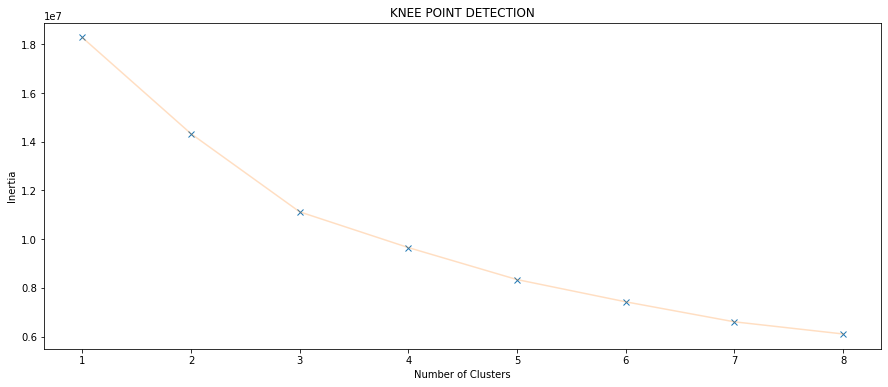

In [15]:
plt.figure(figsize= (15,6))
plt.plot(np.arange(1 , 9) , inertia , 'x')
plt.plot(np.arange(1 , 9) , inertia , '-' , alpha = 0.25)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.title('KNEE POINT DETECTION');

A way to find the knee point is to use the KneeLocator:

In [16]:
kn = KneeLocator(x=list(range (1,9)), y=inertia, curve='convex', direction='decreasing')
print('Optimal number of clusters: ', kn.knee)

Optimal number of clusters:  3


Now I train the model with 3 clusters:

In [17]:
k_cl = KMeans(n_clusters= 3, random_state= 42)
k_cl.fit(data_pca)

KMeans(n_clusters=3, random_state=42)

And then I add a new column 'Cluster' to the original dataset.

In [18]:
data['Cluster'] = k_cl.fit_predict(data_pca)

In [19]:
data.Cluster.unique()

array([0, 1, 2])

Let's visualize and describe each cluster:

In [20]:
data[data['Cluster'] == 0].describe().round(2)

,Month,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Cluster
count,1348843.00,1348843.00,1348843.00,1348843.0,1348843.00,1348843.00,1348843.00,1348843.00,1348843.00,1348843.00,1348843.00,1348843.00,1348843.00,1348843.00,1348843.0
mean,6.10,3.98,14.82,14.4,15.93,15.94,102.17,104.90,80.15,26.14,28.87,533.18,6.17,15.84,0.0
std,3.48,1.99,4.30,4.2,4.88,4.45,36.01,36.29,34.20,24.90,22.95,281.39,3.81,9.19,0.0
min,1.00,1.00,0.00,0.0,0.00,0.00,14.00,-21.00,0.00,-109.00,6.00,11.00,0.00,0.00,0.0
25%,3.00,2.00,12.00,11.0,13.00,13.00,73.00,75.00,52.00,8.00,11.00,303.00,4.00,10.00,0.0
50%,6.00,4.00,15.00,15.0,16.00,16.00,98.00,100.00,75.00,20.00,21.00,490.00,5.00,13.00,0.0
75%,9.00,6.00,18.00,18.0,20.00,20.00,130.00,134.00,106.00,40.00,40.00,742.00,7.00,19.00,0.0
max,12.00,7.00,24.00,23.0,24.00,23.00,221.00,235.00,201.00,174.00,136.00,1455.00,68.00,101.00,0.0


In [21]:
data[data['Cluster'] == 1].describe().round(2)

,Month,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Cluster
count,355910.00,355910.00,355910.00,355910.00,355910.00,355910.00,355910.00,355910.00,355910.00,355910.00,355910.00,355910.00,355910.00,355910.00,355910.0
mean,6.12,4.00,14.22,14.06,15.75,16.10,248.47,250.02,220.30,29.19,30.74,1702.93,7.82,20.35,1.0
std,3.44,1.99,4.72,4.48,6.04,5.39,62.67,62.71,61.33,32.87,27.84,524.16,5.77,13.67,0.0
min,1.00,1.00,0.00,0.00,0.00,0.00,136.00,104.00,59.00,-70.00,6.00,351.00,0.00,0.00,1.0
25%,3.00,2.00,11.00,11.00,13.00,13.00,199.00,201.00,173.00,6.00,11.00,1303.00,5.00,12.00,1.0
50%,6.00,4.00,15.00,14.00,17.00,17.00,233.00,235.00,207.00,22.00,20.00,1597.00,6.00,16.00,1.0
75%,9.00,6.00,18.00,18.00,20.00,20.00,284.00,285.00,257.00,46.00,41.00,2039.00,9.00,24.00,1.0
max,12.00,7.00,24.00,23.00,24.00,23.00,790.00,660.00,664.00,392.00,296.00,4962.00,153.00,251.00,1.0


In [22]:
data[data['Cluster'] == 2].describe().round(2)

,Month,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Cluster
count,223618.00,223618.00,223618.00,223618.00,223618.00,223618.00,223618.00,223618.00,223618.00,223618.00,223618.00,223618.00,223618.00,223618.00,223618.0
mean,6.16,4.01,16.40,14.93,15.17,16.66,137.81,126.60,99.64,159.77,148.55,670.07,9.04,29.14,2.0
std,3.55,2.03,5.04,4.07,7.53,4.49,61.07,54.48,52.66,81.84,86.43,438.09,9.46,28.26,0.0
min,1.00,1.00,0.00,0.00,0.00,0.00,17.00,1.00,0.00,2.00,6.00,11.00,0.00,0.00,2.0
25%,3.00,2.00,14.00,12.00,12.00,14.00,93.00,85.00,61.00,112.00,104.00,337.00,5.00,13.00,2.0
50%,6.00,4.00,17.00,16.00,18.00,18.00,129.00,118.00,91.00,138.00,131.00,594.00,7.00,19.00,2.0
75%,9.00,6.00,20.00,18.00,21.00,20.00,170.00,156.00,127.00,182.00,175.00,888.00,10.00,34.00,2.0
max,12.00,7.00,24.00,23.00,24.00,23.00,1114.00,635.00,1091.00,2461.00,2467.00,4962.00,240.00,422.00,2.0


**Conclussion**:
The k-means model has generated 3 clusters of data.

*Cluster 0* is the most populated. It contains the flights of short distance / small airtime AND either on-time or with relatively small delays.

*Cluster 1* corresponds to flights of medium&long distance, big airtime AND either on-timer or with relatively small delays.

*Cluster 2* corresponds with flights with relatively big delays. It is noticeable that this cluster contains more flights with departure scheduled in the afternoon / evening than the other two.

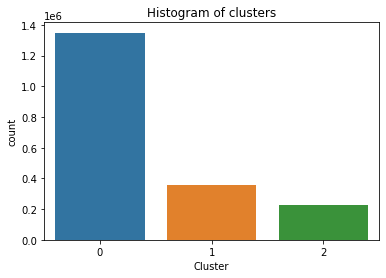

In [23]:
pl = sns.countplot(x=data['Cluster'])
pl.set_title("Histogram of clusters");

In [24]:
data.groupby(['Cluster'])[['AirTime','ArrDelay']].agg([np.mean, np.std, max, min])

AirTime                             ArrDelay                     \
               mean        std     max   min        mean        std     max   
Cluster                                                                       
0         80.151198  34.197756   201.0   0.0   26.140578  24.903872   174.0   
1        220.299151  61.326371   664.0  59.0   29.193709  32.873180   392.0   
2         99.636241  52.659541  1091.0   0.0  159.768735  81.843034  2461.0   

                
           min  
Cluster         
0       -109.0  
1        -70.0  
2          2.0

The scatter plot of AirTime and ArrDelay by cluster shows relatively clear borders among the three clusters:

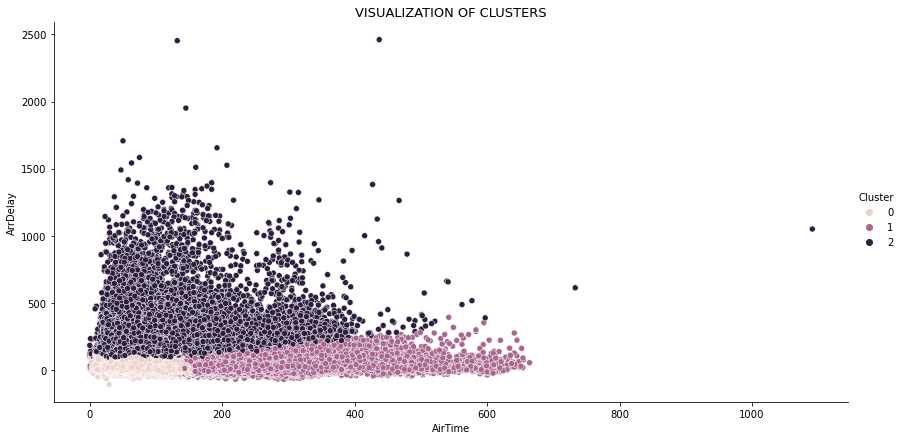

In [29]:
sns.relplot(data=data, x="AirTime", y="ArrDelay", hue = "Cluster", height = 6, aspect = 2)
plt.title('VISUALIZATION OF CLUSTERS', fontsize = 13);

We can visualize that cluster 3 is skewed towards the end of the day:

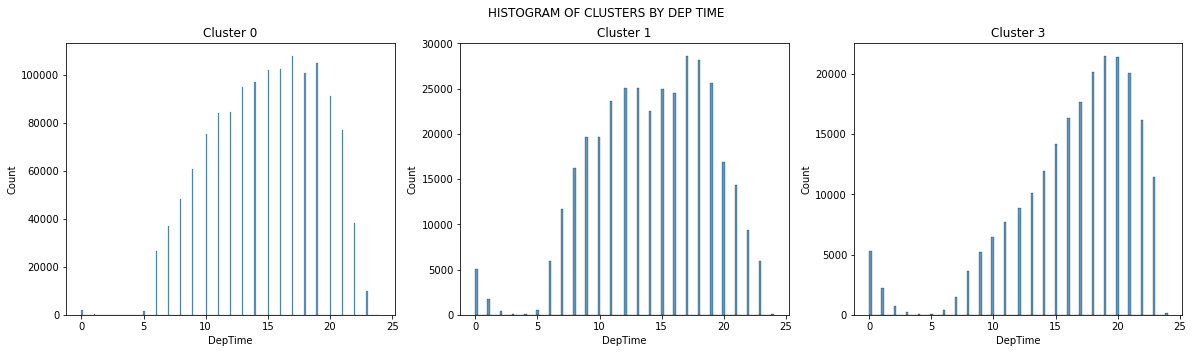

In [47]:
plt.figure(figsize = (20,5))
plt.subplot(1,3,1)
sns.histplot(data=data[data['Cluster'] == 0], x="DepTime")
plt.title('Cluster 0')
plt.subplot(1,3,2)
sns.histplot(data=data[data['Cluster'] == 1], x="DepTime")
plt.title('Cluster 1')
plt.subplot(1,3,3)
sns.histplot(data=data[data['Cluster'] == 2], x="DepTime")
plt.title('Cluster 3')
plt.suptitle('HISTOGRAM OF CLUSTERS BY DEP TIME');

The density plots of AirTime and DepDelay by cluster also explain the main characteristics of each cluster:

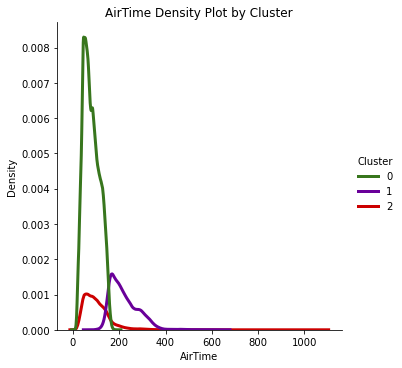

In [59]:
sns.displot(x=data["AirTime"], hue = data["Cluster"], kind = 'kde', palette = ['#38761d', '#690099', '#cc0000'], linewidth = 3)
plt.title('AirTime Density Plot by Cluster');

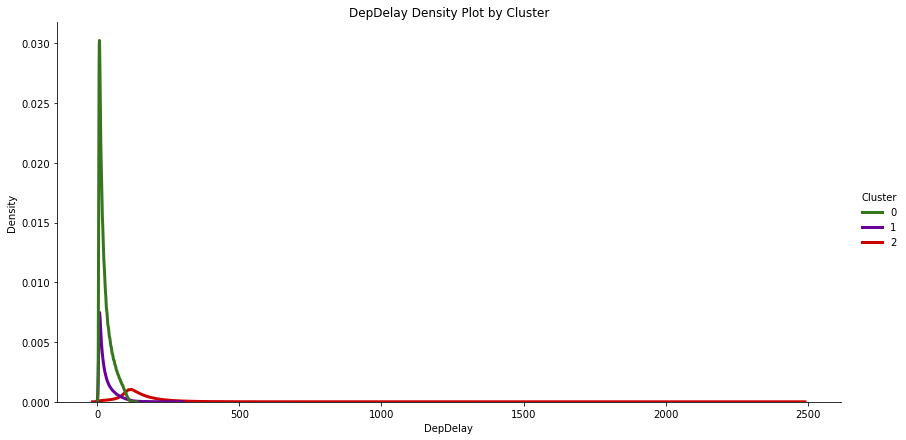

In [58]:
sns.displot(x=data["DepDelay"], hue = data["Cluster"], kind = 'kde', palette = ['#38761d', '#690099', '#cc0000'], linewidth = 3, height = 6, aspect = 2)
plt.title('DepDelay Density Plot by Cluster');

### *Exercici 2*: Agrupa els diferents vols utilitzant l'algorisme de clustering jeràrquic.

Due to computing capacity limitations, I can only take a small sample of 1% of the database to train the hierarchycal clustering model:

In [76]:
data_sample = data.sample(frac=.01, random_state=7)

In [77]:
round(data_sample.describe(),2)

,Month,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Cluster
count,19284.00,19284.00,19284.00,19284.00,19284.00,19284.00,19284.00,19284.00,19284.00,19284.00,19284.00,19284.00,19284.00,19284.00,19284.00
mean,6.13,3.97,14.93,14.42,15.81,16.06,134.07,134.82,109.00,41.84,42.59,771.29,6.82,18.26,0.42
std,3.46,1.99,4.50,4.26,5.50,4.67,72.86,72.09,69.35,56.26,52.62,582.14,5.24,14.39,0.69
min,1.00,1.00,0.00,0.00,0.00,0.00,24.00,15.00,11.00,-42.00,6.00,41.00,0.00,2.00,0.00
25%,3.00,2.00,12.00,11.00,13.00,13.00,80.00,81.00,58.00,9.00,12.00,337.00,4.00,10.00,0.00
50%,6.00,4.00,15.00,15.00,17.00,17.00,117.00,116.00,91.00,24.00,24.00,607.00,5.00,14.00,0.00
75%,9.00,6.00,19.00,18.00,20.00,20.00,166.00,165.00,139.00,55.00,52.00,1005.00,8.00,21.00,1.00
max,12.00,7.00,24.00,23.00,24.00,23.00,645.00,660.00,622.00,1103.00,1100.00,4962.00,132.00,302.00,2.00


I repeat the same feature engineering that I made in the previous exercise prior to train the model.

In [78]:
normalized = ['Month','DayOfWeek','DepTime','CRSDepTime','ArrTime','CRSArrTime']
mms = MinMaxScaler()
Xmms = mms.fit_transform(data_sample[normalized])
standard_names=[]
for i in normalized:
    standard_names.append("norm_"+i)
featured_data_sample = pd.DataFrame(Xmms, columns=standard_names)
standardized = ['ActualElapsedTime','CRSElapsedTime','AirTime', 'ArrDelay', 'DepDelay','Distance','TaxiIn','TaxiOut']
rs = RobustScaler()
Xrs = rs.fit_transform(data_sample[standardized])
standard_names=[]
for i in standardized:
    standard_names.append("stand_"+i)
featured_data = pd.concat([featured_data_sample, pd.DataFrame(Xrs, columns=standard_names)], axis=1)
pca = PCA(.95)
data_sample_pca = pca.fit_transform(featured_data)
pca.n_components_

4

Now I generate and train the Agglomerative Clustering model (hierarchycal). It also requires -as a key parameter- to define the number of clusters. 

A way to select the value of this parameter is to draw a **dendogram**, which groups the data in a succession of bigger clusters, and represents the y-axis the distance between them. The more the distance of the vertical lines in the dendrogram, more the distance between those clusters.

As a rule of thumb:
- we try to set the threshold in such a way that it cuts the tallest vertical line which is not cut by an horizontal line
- we count how many vertical lines are cut by the selected threshold
- this number would be the optimal number of clusters.

In my case, the proposal made by the dendogram is 3, but 4 and 5 would be also acceptable. I will take 3 to reduce the computing time.

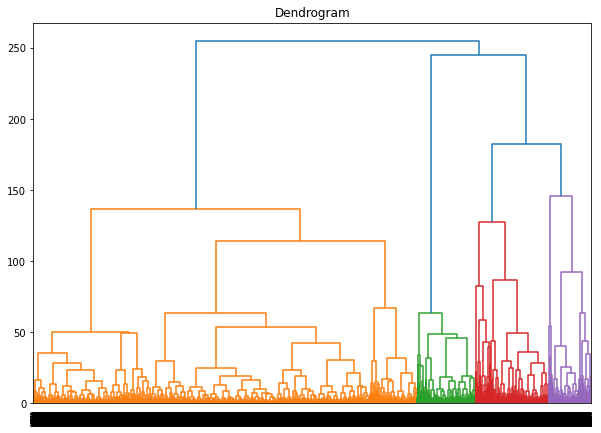

In [79]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrogram")  
dend = shc.dendrogram(shc.linkage(data_sample_pca, method='ward'))

In [91]:
agg_cl = AgglomerativeClustering(n_clusters=3)

In [92]:
agg_cl.fit_predict(data_sample_pca)

array([1, 2, 1, ..., 1, 0, 0], dtype=int64)

And then I add a new column 'Cluster' to the original 1% sample dataset.

In [93]:
data_sample['Cluster']=agg_cl.labels_

In [94]:
data_sample[data_sample['Cluster'] == 0].describe().round(2)

,Month,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Cluster
count,3976.00,3976.00,3976.00,3976.00,3976.00,3976.00,3976.00,3976.00,3976.0,3976.00,3976.00,3976.00,3976.00,3976.00,3976.0
mean,6.18,3.97,15.91,14.76,15.67,16.46,143.52,131.61,103.8,114.72,102.80,705.12,8.24,31.48,0.0
std,3.50,2.00,4.79,4.18,6.77,4.61,65.25,60.52,58.5,79.76,83.67,487.69,8.26,24.12,0.0
min,1.00,1.00,0.00,0.00,0.00,0.00,31.00,32.00,15.0,-25.00,6.00,67.00,0.00,2.00,0.0
25%,3.00,2.00,13.00,12.00,13.00,13.00,96.00,87.00,62.0,65.00,41.00,357.00,4.00,14.00,0.0
50%,6.00,4.00,17.00,15.00,18.00,17.00,129.50,117.50,89.0,100.00,92.00,588.00,6.00,25.00,0.0
75%,9.00,5.00,20.00,18.00,21.00,20.00,177.00,160.00,131.0,144.00,137.00,906.00,9.00,41.00,0.0
max,12.00,7.00,23.00,23.00,24.00,23.00,535.00,490.00,457.0,1103.00,1100.00,4243.00,132.00,302.00,0.0


In [95]:
data_sample[data_sample['Cluster'] == 1].describe().round(2)

,Month,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Cluster
count,13275.00,13275.00,13275.00,13275.00,13275.00,13275.00,13275.00,13275.00,13275.00,13275.00,13275.00,13275.00,13275.00,13275.0,13275.0
mean,6.10,3.96,14.73,14.35,15.90,15.96,108.60,112.56,88.09,22.98,26.94,600.61,6.31,14.2,1.0
std,3.45,1.98,4.31,4.21,4.92,4.49,43.75,44.39,42.35,23.51,21.65,350.21,3.95,6.1,0.0
min,1.00,1.00,0.00,0.00,0.00,0.00,24.00,15.00,11.00,-42.00,6.00,41.00,1.00,2.0,1.0
25%,3.00,2.00,11.00,11.00,13.00,13.00,73.00,75.00,53.00,6.00,11.00,310.50,4.00,10.0,1.0
50%,6.00,4.00,15.00,15.00,16.00,16.00,102.00,105.00,81.00,17.00,19.00,539.00,5.00,13.0,1.0
75%,9.00,6.00,18.00,18.00,20.00,20.00,141.00,145.00,120.00,35.00,37.00,861.00,7.00,17.0,1.0
max,12.00,7.00,24.00,23.00,24.00,23.00,264.00,253.00,232.00,176.00,169.00,1846.00,34.00,42.0,1.0


In [96]:
data_sample[data_sample['Cluster'] == 2].describe().round(2)

,Month,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,Cluster
count,2033.00,2033.00,2033.00,2033.00,2033.00,2033.00,2033.00,2033.00,2033.00,2033.00,2033.00,2033.00,2033.00,2033.00,2033.0
mean,6.20,3.98,14.30,14.21,15.52,15.88,281.89,286.47,255.65,22.46,27.04,2015.18,7.36,18.88,2.0
std,3.44,2.01,4.86,4.64,6.30,5.79,57.26,54.85,52.98,29.80,24.23,450.08,4.34,11.57,0.0
min,1.00,1.00,0.00,0.00,0.00,0.00,177.00,180.00,147.00,-42.00,6.00,1005.00,1.00,5.00,2.0
25%,3.00,2.00,11.00,11.00,12.00,12.00,238.00,245.00,216.00,4.00,10.00,1671.00,5.00,12.00,2.0
50%,6.00,4.00,15.00,14.00,17.00,18.00,271.00,276.00,246.00,17.00,18.00,1946.00,6.00,16.00,2.0
75%,9.00,6.00,18.00,18.00,20.00,20.00,318.00,322.00,289.00,35.00,36.00,2369.00,9.00,22.00,2.0
max,12.00,7.00,23.00,23.00,24.00,23.00,645.00,660.00,622.00,326.00,240.00,4962.00,39.00,122.00,2.0


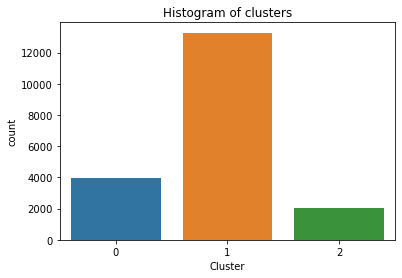

In [97]:
pl = sns.countplot(x=data_sample['Cluster'])
pl.set_title("Histogram of clusters");

**Conclussion**: Not surprisingly in our case the agglomerative clustering model has generated very similar clusters to those generated by k_means:

Cluster 0 corresponds with flights with relatively big delays. It is noticeable that this cluster contains more flights with departure scheduled in the afternoon / evening than the other two.

Cluster 1 is the most populated. It contains the flights of short distance / small airtime AND either on-time or with relatively small delays.

Cluster 2 corresponds to flights of medium&long distance, big airtime AND either on-timer or with relatively small delays.

In [104]:
data_sample.groupby(['Cluster'])[['Distance','ArrDelay', 'DepDelay']].agg([np.mean, max, min])

Distance                ArrDelay                  DepDelay  \
                mean   max   min        mean     max   min        mean   
Cluster                                                                  
0         705.120724  4243    67  114.716801  1103.0 -25.0  102.799547   
1         600.609718  1846    41   22.984708   176.0 -42.0   26.938908   
2        2015.180521  4962  1005   22.459911   326.0 -42.0   27.041810   

                      
            max  min  
Cluster               
0        1100.0  6.0  
1         169.0  6.0  
2         240.0  6.0

**Conclussion**: 

From the visualization of the clusters we can see that in our case k-means delivers better and cleaner boundaries between the clusters versus the agglomerative model.

As a first consideration, we have used significantly less data to train the agglomerative model and thus this could be a reason for that performance.

As a second consideration, Hierarchical clustering methods are very good when the underlying data has a hierarchical structure. As this is not the case, the method doesn't seem to deliver any improvement.

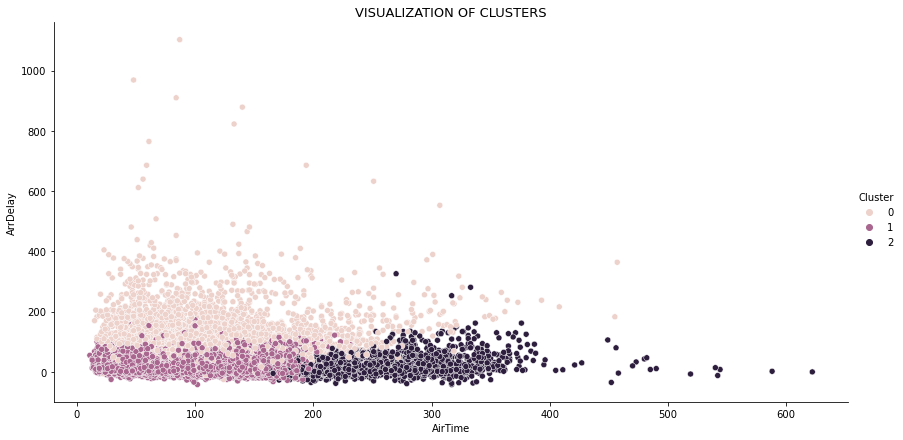

In [101]:
sns.relplot(data=data_sample, x="AirTime", y="ArrDelay", hue = "Cluster", height = 6, aspect = 2)
plt.title('VISUALIZATION OF CLUSTERS', fontsize = 13);

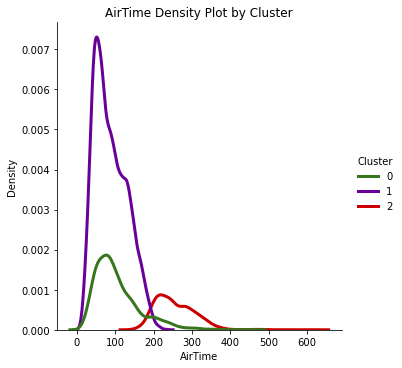

In [106]:
sns.displot(x=data_sample["AirTime"], hue = data_sample["Cluster"], kind = 'kde', palette = ['#38761d', '#690099', '#cc0000'], linewidth = 3)
plt.title('AirTime Density Plot by Cluster');

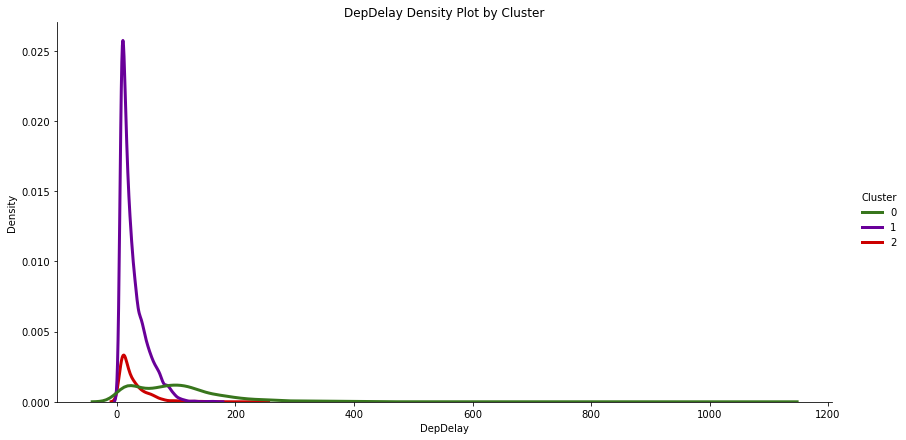

In [109]:
sns.displot(x=data_sample["DepDelay"], hue = data_sample["Cluster"], kind = 'kde', palette = ['#38761d', '#690099', '#cc0000'], linewidth = 3, height = 6, aspect = 2)
plt.title('DepDelay Density Plot by Cluster');

### *Exercici 3*: Calcula el rendiment del clustering mitjançant un paràmetre com pot ser silhouette.

I will calculate the silhouette score through different values of k again. The higher Silhouette scores the higher the distances and the more define the boundaries of the clusters.

In [116]:
silueta = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=7)
    kmeans.fit(data_sample_pca)
    score = silhouette_score(data_sample_pca, kmeans.labels_)
    silueta.append(score)

Differently to inertia, silhouette suggests from 2 to 5 clusters with very similar score for kmeans. 5 would the optimum

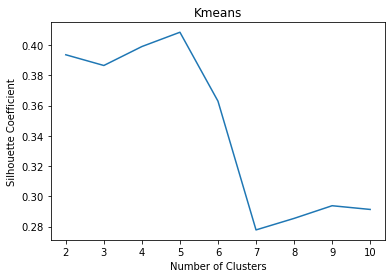

In [117]:
plt.plot(range(2, 11), silueta)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title('Kmeans')
plt.show()

In [113]:
silueta = []
for k in range(2, 11):
    agg_cl = AgglomerativeClustering(n_clusters=k)
    agg_cl.fit(data_sample_pca)
    score = silhouette_score(data_sample_pca, agg_cl.labels_)
    silueta.append(score)

**Conclussion**:

For Agglomerative Clustering, silhouette suggests from 4 to 5 clusters with very similar score. 4 would be the optimum. I notice that the scores are lower than for kmeans, which confirms that the boundaries with agglomerative clustering are less clean than with kmeans.

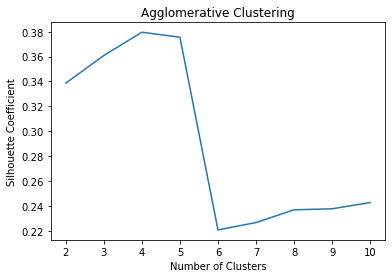

In [115]:
plt.plot(range(2, 11), silueta)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title('Agglomerative Clustering')
plt.show()